In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
sample_count = 150

X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

# Test set
sample_count = 50

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
idx = np.append(
    np.where(X_test.targets == 0)[0][:sample_count],
    np.where(X_test.targets == 1)[0][:sample_count],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [4]:
class QuantumCircuit:
    """This class defines the quantum circuit structure and the run method which is used to calculate an expectation value"""

    def __init__(self, qubit_count: int):
        """Define the quantum circuit in CUDA Quantum"""

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel

        self.theta = thetas

        qubits = kernel.qalloc(qubit_count)

        self.kernel.h(qubits)

        # Variational gate parameters which are optimised during training
        for i in range(qubit_count):
            kernel.rx(thetas[16*i], qubits[i])
            if i != qubit_count-1:
                kernel.crx(thetas[16*i+1],qubits[i],qubits[i+1])
            else:
                kernel.crx(thetas[16*i+1],qubits[i],qubits[0])
            kernel.ry(thetas[16*i+2], qubits[i])
            if i != qubit_count-1:
                kernel.cry(thetas[16*i+3],qubits[i],qubits[i+1])
            else:
                kernel.cry(thetas[16*i+3],qubits[i],qubits[0])
            kernel.rz(thetas[16*i+4], qubits[i])
            if i != qubit_count-1:
                kernel.crz(thetas[16*i+5],qubits[i],qubits[i+1])
            else:
                kernel.crz(thetas[16*i+5],qubits[i],qubits[0])
            kernel.rx(thetas[16*i+6], qubits[i])
            if i != qubit_count-1:
                kernel.crx(thetas[16*i+7],qubits[i],qubits[i+1])
            else:
                kernel.crx(thetas[16*i+7],qubits[i],qubits[0])
            kernel.ry(thetas[16*i+8], qubits[i])
            if i != qubit_count-1:
                kernel.cry(thetas[16*i+9],qubits[i],qubits[i+1])
            else:
                kernel.cry(thetas[16*i+9],qubits[i],qubits[0])
            kernel.rz(thetas[16*i+10], qubits[i])
            if i != qubit_count-1:
                kernel.crz(thetas[16*i+11],qubits[i],qubits[i+1])
            else:
                kernel.crz(thetas[16*i+11],qubits[i],qubits[0])
            kernel.rx(thetas[16*i+12], qubits[i])
            if i != qubit_count-1:
                kernel.crx(thetas[16*i+13],qubits[i],qubits[i+1])
            else:
                kernel.crx(thetas[16*i+13],qubits[i],qubits[0])
            kernel.ry(thetas[16*i+14], qubits[i])
            if i != qubit_count-1:
                kernel.cry(thetas[16*i+15],qubits[i],qubits[i+1])
            else:
                kernel.cry(thetas[16*i+15],qubits[i],qubits[0])

        hamiltonian = spin.z(0)
        for i in range(1, qubit_count):
            hamiltonian *= spin.z(i)
        self.hamiltonian = hamiltonian

    def run(self, thetas: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""
        expectation = torch.tensor(cudaq.observe(self.kernel, self.hamiltonian,
                                                 thetas).expectation(),
                                   device=device)

        return expectation
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:
        # Save shift and quantum_circuit in context to use in backward
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate exp_val
        expectation_z = ctx.quantum_circuit.run(thetas)

        ctx.save_for_backward(thetas, expectation_z)
        return expectation_z

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation_z = ctx.saved_tensors

        gradients = torch.zeros(len(thetas), device=device)

        for i in range(len(thetas)):
            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift

            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = 0.5 * (expectation_right - expectation_left)

        return gradients * grad_output.float(), None, None

In [ ]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumCircuit(2)
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)
        return ans
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Neural network structure
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 32)
        self.hybrid = QuantumLayer(
            torch.tensor(np.pi / 2)
        )  # Input is the magnitude of the parameter shifts to calculate gradients

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x)).reshape(-1)
        x = self.hybrid(x).reshape(-1)
        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [5]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumCircuit(2)
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)
        return ans
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Neural network structure
        self.fc0 = nn.Linear(784, 256)
        self.fc1 = nn.Linear(256, 32)
        self.hybrid = QuantumLayer(
            torch.tensor(np.pi / 2)
        )  # Input is the magnitude of the parameter shifts to calculate gradients

    def forward(self, x):
        x = x.view(1, -1)
        x = F.relu(self.fc0(x)).reshape(-1)
        x = F.relu(self.fc1(x)).reshape(-1)
        x = self.hybrid(x).reshape(-1)
        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [6]:
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 20

epoch_loss = []

model.train()
for epoch in range(epochs):
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):  # batch training
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data).to(device)

        # Calculating loss
        loss = loss_func(output, target).to(device)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        batch_loss += loss.item()

    epoch_loss.append(batch_loss / batch_idx)

    print("Training [{:.0f}%]\tLoss: {:.4f}".format(
        100.0 * (epoch + 1) / epochs, epoch_loss[-1]))

Training [5%]	Loss: -1.3568
Training [10%]	Loss: -1.4652
Training [15%]	Loss: -1.4846
Training [20%]	Loss: -1.4879
Training [25%]	Loss: -1.4922
Training [30%]	Loss: -1.4962
Training [35%]	Loss: -1.4991
Training [40%]	Loss: -1.4997
Training [45%]	Loss: -1.4987
Training [50%]	Loss: -1.4946
Training [55%]	Loss: -1.5003
Training [60%]	Loss: -1.5017
Training [65%]	Loss: -1.5006
Training [70%]	Loss: -1.4988
Training [75%]	Loss: -1.4963
Training [80%]	Loss: -1.4901
Training [85%]	Loss: -1.4986
Training [90%]	Loss: -1.4979
Training [95%]	Loss: -1.4999
Training [100%]	Loss: -1.5009


Text(0, 0.5, 'Neg Log Likelihood Loss')

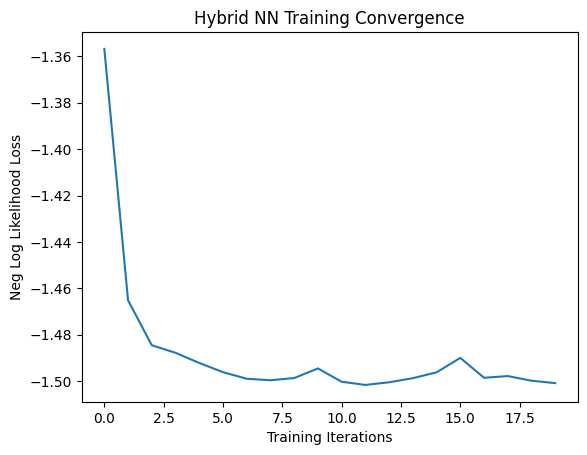

In [7]:
plt.plot(epoch_loss)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")

plt.ylabel("Neg Log Likelihood Loss")

In [8]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        epoch_loss.append(loss.item())

    print("Performance on test data:\n\tAccuracy: {:.1f}%".format(
        correct / len(test_loader) * 100))

Performance on test data:
	Accuracy: 100.0%
